# Cartpole Example
This example demonstrates global adversarial stress testing in the classic inverted pendulum environment. 
- **System under test:** pre-trained DQN controller with very low natural rate of failure.
- **Failure criterion:** inverted pendulum exceeds threshold angle or cart exceeds theshold distance from origin. 
- **Stochastic disturbance:** wind gusts in horizontal direction, normally distributed in strength.

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating environment at `C:\Users\rlipkis\.julia\dev\adastress\examples\cartpole\Project.toml`


# Loading cart-pole controller (SUT)

In [2]:
# to learn
using ReinforcementLearning
using ReinforcementLearningExperiments

# to load
using BSON
using Flux
using NNlib
using Random
using ReinforcementLearningCore
using ReinforcementLearningZoo
using StableRNGs

In [3]:
# This function can be invoked to re-train the DQN policy if desired.
function learn_policy()
    ex = E`JuliaRL_BasicDQN_CartPole`
    ex.stop_condition = StopAfterStep(100_000)
    run(ex)
    learned_policy = ex.policy.policy
    learned_policy.explorer.is_training = false
    bson("dqn_policy.bson", policy = learned_policy)
end

learn_policy (generic function with 1 method)

In [4]:
load_policy() = BSON.load("dqn_policy.bson")[:policy]

load_policy (generic function with 1 method)

# Simulation

In [5]:
using Random
using CommonRLInterface
using AdaStress
import AdaStress.Interface as ASTInterface
using Distributions
using Plots
using ProgressMeter
ProgressMeter.ijulia_behavior(:clear)

false

In [6]:
Base.@kwdef mutable struct CartPoleSim <: ASTInterface.GrayBox
    env::ReinforcementLearning.AbstractEnv = CartPoleEnv()
    tmax::Float64 = 50.0 #100.0
    pi::ReinforcementLearning.AbstractPolicy = load_policy()
    x_dist::ASTInterface.Environment = ASTInterface.Environment(:wind => Normal(0.0, 0.01))
    log::Dict{Symbol, Any} = Dict{Symbol, Any}()
    logging::Bool = false
end

CartPoleSim

In [7]:
function ASTInterface.reset!(sim::CartPoleSim)
    ReinforcementLearning.reset!(sim.env)
    if sim.logging
        sim.log[:s] = []
        sim.log[:x] = []
        sim.log[:a] = []
        push!(sim.log[:s], ASTInterface.observe(sim))
    end
end

ASTInterface.environment(sim::CartPoleSim) = sim.x_dist

ASTInterface.observe(sim::CartPoleSim) = copy(ReinforcementLearning.state(sim.env))

function ASTInterface.step!(sim::CartPoleSim, x::ASTInterface.EnvironmentValue)
    a = sim.pi(sim.env)
    s = ReinforcementLearning.state(sim.env)
    s[2] += x[:wind]
    sim.env(a)
    if sim.logging
        push!(sim.log[:s], ASTInterface.observe(sim))
        push!(sim.log[:x], x[:wind])
        push!(sim.log[:a], a)
    end     
end

ASTInterface.isterminal(sim::CartPoleSim) = sim.env.t >= sim.tmax

function ASTInterface.isevent(sim::CartPoleSim)
    state, params = sim.env.state, sim.env.params
    return abs(state[1]) > params.xthreshold || abs(state[3]) > params.thetathreshold
end

interval_dist(x::Real, r::Real) = interval_dist(x, -r, r)

interval_dist(x::Real, l::Real, u::Real) = (l < x < u) ? min(x - l, u - x) : zero(x)

function ASTInterface.distance(sim::CartPoleSim)
    s = ReinforcementLearning.state(sim.env)
    dx = interval_dist(s[1], sim.env.params.xthreshold)
    dθ = interval_dist(s[3], sim.env.params.thetathreshold)
    d = sqrt(dx^2 + dθ^2)
    return d
end

# Trajectory examples (undisturbed)

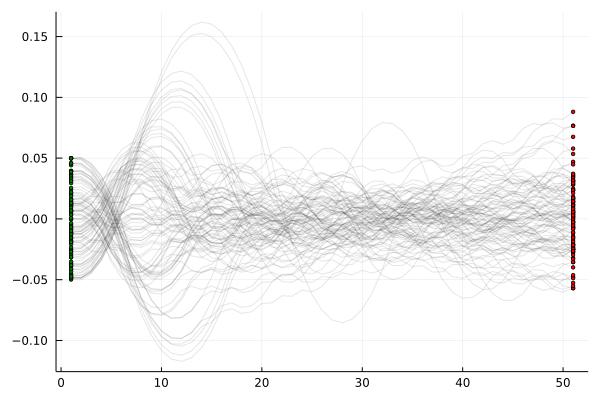

In [8]:
Random.seed!(0)
p = plot()
sim = CartPoleSim(logging=true)

for _ in 1:100
    ASTInterface.reset!(sim)
    while !(ASTInterface.isterminal(sim) || ASTInterface.isevent(sim))
        x = rand(sim.x_dist; flat=false)
        ASTInterface.step!(sim, x)
    end
    τ = collect(1:length(sim.log[:s]))
    q = getindex.(sim.log[:s], 3)
    plot!(p, τ, q, label=:none, lc=:black, alpha=0.1)
    scatter!(p, [τ[1]], [q[1]], mc=:green, ms=2.0, label=:none)
    scatter!(p, [τ[end]], [q[end]], mc=:red, ms=2.0, label=:none)
end
p

# Failure prevalence (undisturbed)

In [9]:
Random.seed!(0)
c = 0
N = 1_000_000

ASTInterface.reset!(sim)
@showprogress for _ in 1:N
    x = rand(sim.x_dist; flat=false)
    ASTInterface.step!(sim, x)
    d, e = ASTInterface.isterminal(sim), ASTInterface.isevent(sim)
    c += e
    (d || e) && ASTInterface.reset!(sim)
end
rate = c / N

Progress: 100%|█████████████████████████████████████████| Time: 0:00:0839m39m


0.0

# AST

In [10]:
function mdp_env(σ::Float64)
    mdp = ASTInterface.ASTMDP(CartPoleSim())
    mdp.reward.event_bonus = 100.0
    mdp.sim.x_dist[:wind] = Normal(0.0, σ)
    return mdp
end

mdp_env (generic function with 1 method)

# Single run

In [11]:
Random.seed!(0)

sac = AdaStress.SoftActorCritic.SAC(;
    obs_dim=4, 
    act_dim=1,
    act_mins=-3.0*ones(1),
    act_maxs=3.0*ones(1),
    hidden_sizes=[30,30,30],
    q_optimizer=AdaStress.SoftActorCritic.AdaBelief(1e-4),
    pi_optimizer=AdaStress.SoftActorCritic.AdaBelief(1e-4),
    alpha_optimizer=AdaStress.SoftActorCritic.AdaBelief(1e-4),
    gamma=1.0,
    num_q=3,
    max_buffer_size=100_000,
    batch_size=1024,
    epochs=150,
    steps_per_epoch=1_000,
    start_steps=10_000,
    max_ep_len=100,
    update_after=10_000,
    update_every=1_000,
    num_batches=100,
    num_test_episodes=100,
    displays=[(:fails, mdp->ASTInterface.isevent(mdp.sim))]
)

ac, info = sac(() -> mdp_env(0.1))

Progress: 100%|█████████████████████████████████████████| Time: 0:07:28
  epoch:  150
  score:  95.90382
  stdev:  0.21492001
  fails:  1.0


(AdaStress.Solvers.SoftActorCritic.MLPActorCritic(AdaStress.Solvers.SoftActorCritic.SquashedGaussianMLPActor(Chain(Dense(4, 30, relu), Dense(30, 30, relu), Dense(30, 30, relu)), Dense(30, 1), Dense(30, 1), Float32[-3.0], Float32[3.0], Random._GLOBAL_RNG(), CUDA.CURAND.RNG(Ptr{Nothing} @0x0000000055361280, CuContext(0x0000000052324f40, instance f4040aabf870c63d, invalidated), CuStream(0x000000005ae78690, CuContext(0x0000000052324f40, instance f4040aabf870c63d, invalidated)), 100)), AdaStress.Solvers.SoftActorCritic.MLPQFunction[AdaStress.Solvers.SoftActorCritic.MLPQFunction(Chain(Dense(5, 30, relu), Dense(30, 30, relu), Dense(30, 30, relu), Dense(30, 1))), AdaStress.Solvers.SoftActorCritic.MLPQFunction(Chain(Dense(5, 30, relu), Dense(30, 30, relu), Dense(30, 30, relu), Dense(30, 1))), AdaStress.Solvers.SoftActorCritic.MLPQFunction(Chain(Dense(5, 30, relu), Dense(30, 30, relu), Dense(30, 30, relu), Dense(30, 1)))]), Dict{String, Any}("score" => Any[0.0067934734f0, 0.0068977214f0, 0.01033

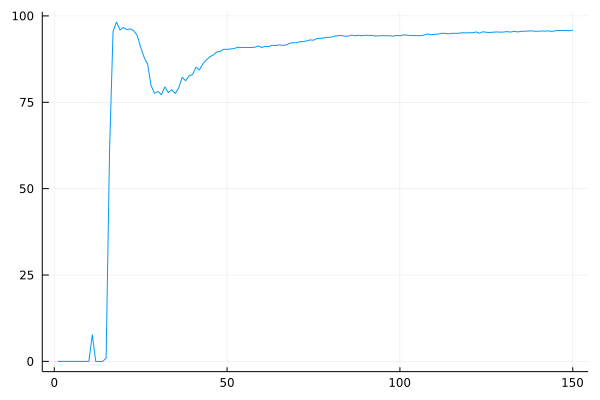

In [12]:
plot(info["score"]; label=:none)

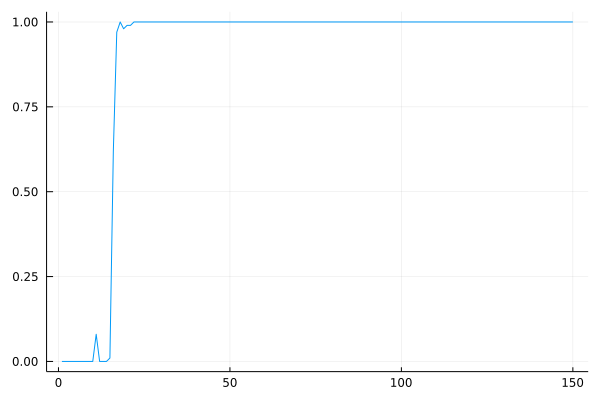

In [13]:
plot(info["fails"]; label=:none)

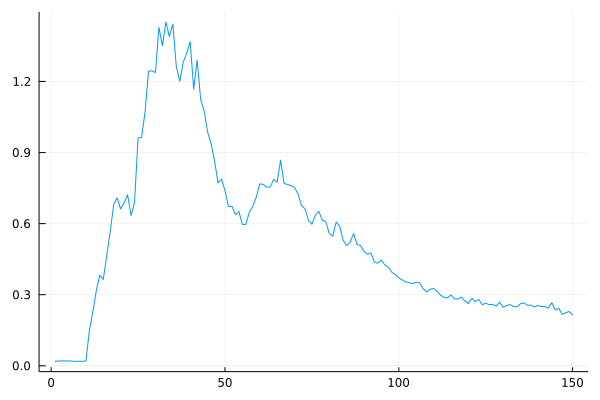

In [14]:
plot(info["stdev"]; label=:none)

# Sample trajectories

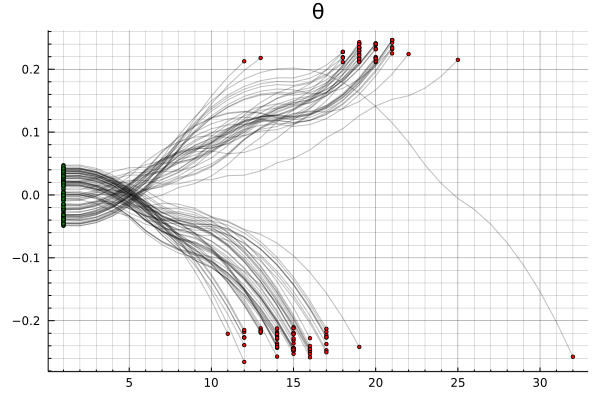

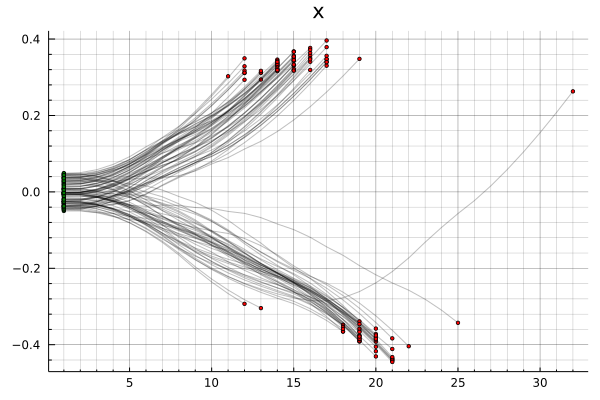

In [15]:
Random.seed!(0)
pθ = plot(; title="\\theta", ga=0.5, minorgrid=true, minorgridalpha=0.25)
px = plot(; title="x", ga=0.5, minorgrid=true, minorgridalpha=0.25)
mdp = mdp_env(0.1)
mdp.sim.logging = true

for _ in 1:100
    CommonRLInterface.reset!(mdp)
    while !terminated(mdp)
        a = ac(Float32.(CommonRLInterface.observe(mdp)), true)
        act!(mdp, a)
    end
    
    τ = collect(1:length(mdp.sim.log[:s]))
    
    θ = getindex.(mdp.sim.log[:s], 3)
    plot!(pθ, τ, θ, label=:none, lc=:black, alpha=0.25)
    scatter!(pθ, [τ[1]], [θ[1]], mc=:green, ms=2.0, label=:none)
    scatter!(pθ, [τ[end]], [θ[end]], mc=:red, ms=2.0, label=:none)
    
    x = getindex.(mdp.sim.log[:s], 1)
    plot!(px, τ, x, label=:none, lc=:black, alpha=0.25)
    scatter!(px, [τ[1]], [x[1]], mc=:green, ms=2.0, label=:none)
    scatter!(px, [τ[end]], [x[end]], mc=:red, ms=2.0, label=:none)
end
display(pθ)
display(px)

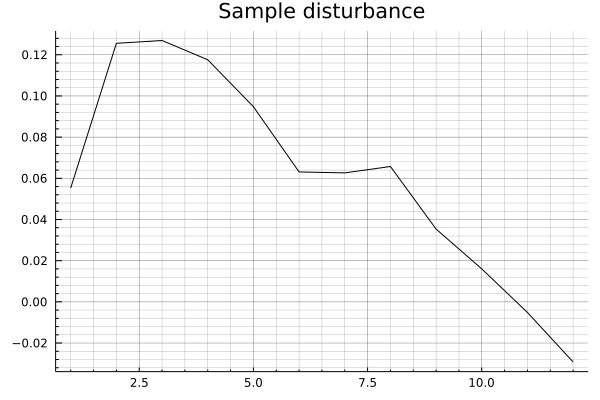

In [16]:
plot(mdp.sim.log[:x]; title="Sample disturbance", label=:none, lc=:black, ga=0.5, minorgrid=true, minorgridalpha=0.25)

# Animation

In [17]:
function Circle(xc::Real, yc::Real, r::Real; n::Int64=100)
    θ = range(0, 2π; length=n+1)
    xs = @. xc + r*cos(θ)
    ys = @. yc + r*sin(θ)
    return Shape(xs, ys)
end

function Rectangle(xc::Real, yc::Real, l::Real, h::Real)
    xs = [xc - l/2, xc + l/2, xc + l/2, xc - l/2]
    ys = [yc - h/2, yc - h/2, yc + h/2, yc + h/2]
    return Shape(xs, ys)
end

Rectangle (generic function with 1 method)

In [18]:
function movie(sim::CartPoleSim, filename::String="animation")
    cart_length = 0.5
    cart_height = 0.25
    wheel_offset = 0.2
    wheel_height = 0.025
    wheel_radius = 0.05
    pole_length = 1.0

    x_grid = 10
    y_grid = 5
    σ_max = 3
    xlim = sim.env.params.xthreshold * [-1, 1]
    ylim = [0, cart_height + pole_length + 0.1]
    xs = range(xlim..., length=x_grid)
    ys = range(ylim..., length=y_grid)
    X = [x for x in xs for y in ys]
    Y = [y for x in xs for y in ys]
    h = xs[2] - xs[1]

    log = sim.log
    anim = @animate for i in 1:length(log[:s])
        x = log[:s][i][1]
        θ = log[:s][i][3]
        i_trunc = min(i, length(log[:s]) - 1)
        a = log[:a][i_trunc]
        w = log[:x][i_trunc] * 10

        # empty scene
        p = plot(; 
            xlim=xlim, 
            ylim=ylim, 
            yaxis=false, 
            minorticks=10, 
            yticks=false, 
            aspect_ratio=:equal, 
            label=:none
        )

        # wind disturbance
        quiver!(p, X, Y; quiver=(x,y)->[w, 0.0], lc=:dodgerblue)

        # pole
        color = abs(θ) < sim.env.params.thetathreshold ? :blue : :red
        x_pole, y_pole = x, cart_height
        xs = x_pole .+ [0, pole_length] * sin(θ)
        ys = y_pole .+ [0, pole_length] * cos(θ)
        plot!(p, xs, ys; lw=5, lc=color, label=:none)
        scatter!(p, [xs[1]], [ys[1]]; ms=5, mc=color, label=:none)
        scatter!(p, [xs[2]], [ys[2]]; ms=8, mc=color, label=:none)

        # cart body
        color = abs(x) < sim.env.params.xthreshold ? :gray : :red
        plot!(p, Rectangle(x, cart_height/2, cart_length, cart_height); fill=color, label=:none)

        # cart wheels
        plot!(p, Circle(x + wheel_offset, wheel_height, wheel_radius); lw=2, fill=:gray, label=:none)
        plot!(p, Circle(x - wheel_offset, wheel_height, wheel_radius); lw=2, fill=:gray, label=:none)

        # controller force
        dir = a == 2 ? 1 : -1
        xs = (x - dir * cart_length / 2) * [1, 1] .- dir * [0.25, 0]
        ys = cart_height / 2 * [1, 1] 
        plot!(p, xs, ys; arrow=true, lc=:red, lw=4, label=:none)

        p
    end

    return gif(anim, "$filename.mp4", fps = 15)
end

movie (generic function with 2 methods)

In [19]:
Random.seed!(0)
p = plot()
mdp = mdp_env(0.1)
mdp.sim.logging = true

CommonRLInterface.reset!(mdp)
while !terminated(mdp)
    a = ac(Float32.(CommonRLInterface.observe(mdp)), true)
    act!(mdp, a)
end
movie(mdp.sim)

┌ Info: Saved animation to 
│   fn = C:\Users\rlipkis\.julia\dev\adastress\examples\cartpole\animation.mp4
└ @ Plots C:\Users\rlipkis\.julia\packages\Plots\CoJwR\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\rlipkis\\.julia\\dev\\adastress\\examples\\cartpole\\animation.mp4")